# State Farm Distracted Driver Detection: Revisited
_Can computer vision spot distracted drivers?_

---

## Lesson 2 Homework Assignment

"Try to set up the data, train a model, and submit your predictions for this competition using only code that you write from scratch. If you look at the code provided for the class to get help, don't copy and paste it - but instead read the source code for vgg16.py and utils.py, and the keras documentation, and try to write and debug your own version"

Dataset: https://www.kaggle.com/c/state-farm-distracted-driver-detection

In [1]:
import os

current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir + '/data/statefarm/'

# point to your training images
train_dir = DATA_HOME_DIR + 'train'

# point to the 'driver_imgs_list.csv'
lookup = DATA_HOME_DIR + 'driver_imgs_list.csv'

# point to the validation directory, which will be created in the next block
val_dir = DATA_HOME_DIR + 'valid'

sample_dir = DATA_HOME_DIR + 'sample'

### Download dataset using the [Kaggle CLI](http://wiki.fast.ai/index.php/Kaggle_CLI):

After running `kg config -g -u <username> -p <password> -c state-farm-distracted-driver-detection`

In [ ]:
%cd $DATA_HOME_DIR

In [ ]:
!kg download
!unzip sample_submission.csv.zip
!unzip imgs.zip
!unzip driver_imgs_list.csv.zip

In [ ]:
%cd $LESSON_HOME_DIR

### Create the validation set ([help](http://forums.fast.ai/t/how-to-create-the-state-farm-comp-validation-set/1306)):

In [2]:
import glob
import random
import pandas as pd
import numpy as np
import shutil

In [3]:
# creates a directory, called 'valid', and into it, creates 10 subdirs, one for each class.
# TODO: rewrite this using sample set implementation

if not os.path.exists(val_dir):
    os.makedirs(val_dir)
    [os.mkdir('{}/c{}'.format(val_dir, i)) for i in range(10)]
    # read in the 'driver_imgs_list.csv' file
    df = pd.read_csv(lookup)
    # Pick 20% (1/5) of the drivers at random
    driver_names_for_validation = random.sample(drivers, drivers.size / 5)
    # filter df by selecting rows with the subjects we want
    df = df[df['subject'].isin(driver_names_for_validation)]
    # do the move here:
    i = 0
    for index, row in df.iterrows():
        to_move = train_dir + '/' +  row['classname'] + '/' + row['img']
        i = i + 1
        move_to = val_dir + '/' +  row['classname']
        shutil.move(to_move, move_to)
    print 'files to move: ', df.shape[0]
    print 'files moved:   ', i

### Create the sample set ([help](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/statefarm-sample.ipynb))

In [4]:
from shutil import copyfile
from glob import glob

if not os.path.exists(sample_dir + '/train'):
    os.makedirs(sample_dir + '/train')
    %cd $train_dir
    for d in glob('c?'):
        os.mkdir(sample_dir + '/train/' + d)
    g = glob('c?/*.jpg')
    shuf = np.random.permutation(g)
    for i in range(1500): copyfile(shuf[i], sample_dir + '/train/' + shuf[i])

if not os.path.exists(sample_dir + '/valid'):
    os.makedirs(sample_dir + '/valid')
    %cd $val_dir
    for d in glob('c?'):
        os.mkdir(sample_dir + '/valid/' + d)
    g = glob('c?/*.jpg')
    shuf = np.random.permutation(g)
    for i in range(1000): copyfile(shuf[i], sample_dir + '/valid/' + shuf[i])
        
%cd $LESSON_HOME_DIR

/home/ubuntu/hmwk/nbs


### Basic Configuration

In [5]:
%matplotlib inline

In [6]:
#path = DATA_HOME_DIR + 'sample/'
path = DATA_HOME_DIR
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [7]:
import utils; reload(utils)
from utils import *

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [8]:
# As large as you can, but no larger than 64 is recommended. 
# If you have an older or cheaper GPU, you'll run out of memory, so will have to decrease this.
batch_size=64

Loading and resizing the images every time we want to use them isn't necessary - instead we should save the processed arrays. By far the fastest way to save and load numpy arrays is using bcolz. This also compresses the arrays, so we save disk space. Here are the functions we'll use to save and load using bcolz.

In [9]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

Keras returns classes as a single column, so we convert to one hot encoding

In [10]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

A simple function for fitting models that saves us a little typing

In [11]:
def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, samples_per_epoch=batches.N, nb_epoch=nb_epoch, 
                        validation_data=val_batches, nb_val_samples=val_batches.N)

### Prepare the data


Our overall approach here will be:
1. Get the true labels for every image
2. Get the 1,000 imagenet category predictions for every image
3. Feed these predictions as input to a simple linear model.

In [12]:
# Import Vgg16, and instantiate
import vgg16; reload(vgg16)
from vgg16 import Vgg16

vgg = Vgg16()
model = vgg.model

Grab training and validation batches...

In [38]:
# Use batch size of 1 since we're just doing preprocessing on the CPU
val_batches = get_batches(path+'valid', shuffle=False, batch_size=1)
trn_batches = get_batches(path+'train', shuffle=False, batch_size=1)

Found 4320 images belonging to 10 classes.
Found 18104 images belonging to 10 classes.


Let's look at the class data for these batches, in both single-column and one-hot encoded forms

In [14]:
val_classes = val_batches.classes
trn_classes = trn_batches.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

In [15]:
trn_classes.shape, trn_labels.shape

((18104,), (18104, 10))

In [16]:
trn_classes[:4], trn_labels[:4]

(array([0, 0, 0, 0], dtype=int32),
 array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]))

Now we have the labels. Let's get the datasets we want to predict on next.

Note that `get_data` runs `get_batches` and then concatenates the arrays from all the batches

In [17]:
??get_data

In [18]:
trn_data_path = model_path+'train_data.bc';
val_data_path = model_path+'valid_data.bc';

if os.path.exists(trn_data_path):
    trn_data = load_array(trn_data_path)
else:
    trn_data = get_data(path+'train')
    save_array(trn_data_path, trn_data)
    
if os.path.exists(val_data_path):
    val_data = load_array(val_data_path)
else:
    val_data = get_data(path+'valid')
    save_array(val_data_path, val_data)

Found 18104 images belonging to 10 classes.
Found 4320 images belonging to 10 classes.


I've surmised that `.shape` here represents (num_images, num_values_per_pixel (RGB=3), width_in_pixels, height_in_pixels). Not 100% positive though.

In [19]:
trn_data.shape, val_data.shape

((18104, 3, 224, 224), (4320, 3, 224, 224))

### Finetuning for State Farm

If we take a look at our Vgg model, we'll see that the final layer is a dense.

In [20]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

The final dense layer is what mapped the final intermediate layer to the categories specified by the ImageNet competition. Since we'd like to map to different categories, let's replace this final dense layer with our own (this is what _finetuning_ essentially is!)

In [21]:
??vgg.finetune

In [22]:
model.pop()
for layer in model.layers: layer.trainable=False

Note that we fix the weights in all the remaining layers by setting `layer.trainable=False` - we aren't looking to learn new parameters for these others, only our new linear layer.

In [23]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  0           zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

### Train linear model on predictions

In [24]:
model.add(Dense(10, activation='softmax'))

In [25]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  0           zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

Time to set our batches to use the preprocessed images and layers prepped earlier (_shuffling_ the training batches this time to add more randomness in our epochs), compile our updated model, and fit the last layer of the model.

In [26]:
# TODO: rename trn_batches, val_batches to not conflict with above definitions
gen=image.ImageDataGenerator()
trn_batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

In [27]:
model.compile(RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
fit_model(model, trn_batches, val_batches, nb_epoch=3)

Epoch 1/3
18104/18104 [==============================] - 550s - loss: 14.0563 - acc: 0.1247 - val_loss: 13.8792 - val_acc: 0.1377
Epoch 2/3
18104/18104 [==============================] - 551s - loss: 13.7498 - acc: 0.1464 - val_loss: 14.1173 - val_acc: 0.1241
Epoch 3/3
18104/18104 [==============================] - 550s - loss: 13.7294 - acc: 0.1471 - val_loss: 13.6851 - val_acc: 0.1498


Save weights now for reuse.

In [29]:
finetune1_path = model_path+'finetune1.h5'
if not os.path.exists(finetune1_path):
    model.save_weights(finetune1_path)
model.load_weights(finetune1_path)

### Evaluation

In [30]:
model.evaluate(val_data, val_labels)

4320/4320 [==============================] - 108s   


[13.685088186793857, 0.14976851851851852]

In [31]:
preds = model.predict_classes(val_data, batch_size=batch_size)
probs = model.predict_proba(val_data, batch_size=batch_size)[:,0]
probs[:8]

4320/4320 [==============================] - 105s   


array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32)

In [32]:
cm = confusion_matrix(val_classes, preds)

Class names provided by: https://www.kaggle.com/c/state-farm-distracted-driver-detection#evaluation
- c0: normal driving
- c1: texting - right
- c2: talking on the phone - right
- c3: texting - left
- c4: talking on the phone - left
- c5: operating the radio
- c6: drinking
- c7: reaching behind
- c8: hair and makeup
- c9: talking to passenger

[[395   0   0   0   0   0   0  62   0   0]
 [279   0   0   0   0   0   0 193   0   0]
 [302   0  10   0   0   0   0 152   0   0]
 [406   0   0   0   0   0   0  58   0   0]
 [366   0   0   0   0   0   0 106   0   0]
 [265   0   0   0   0   0   0 209   0   0]
 [305   0   0   0   0   0   0 142   0   0]
 [144   0   0   0   0   0   0 242   0   0]
 [207   0  11   0   0   0   0 119   0   0]
 [276   0   1   0   0   0   0  70   0   0]]


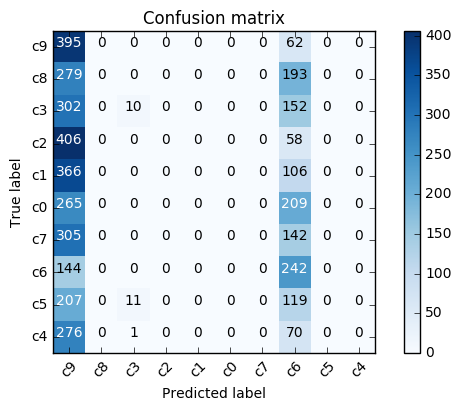

In [43]:
plot_confusion_matrix(cm, val_batches.class_indices)

These results are much poorer than I was expecting. Strange how:
1. The majority the predictions fall into 2/10 categories, c9 and c6
2. The probabilities are frequently 0 or 1 (perhaps clipping would help?)

### Viewing model prediction examples

Let's see if we can spot what's gone so awry here. Perhaps we are overfitting?

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).
Let's see what, if anything, we can from these (in general, these are particularly useful for debugging problems in the model; since this model is so simple, there may not be too much to learn at this stage.)

Helper function to plot images by index in the validation set

In [50]:
def plots_idx(idx, titles=None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles=titles)

In [46]:
filenames = val_batches.filenames

In [49]:
# Number of images to view for each visualization task
n_view = 4

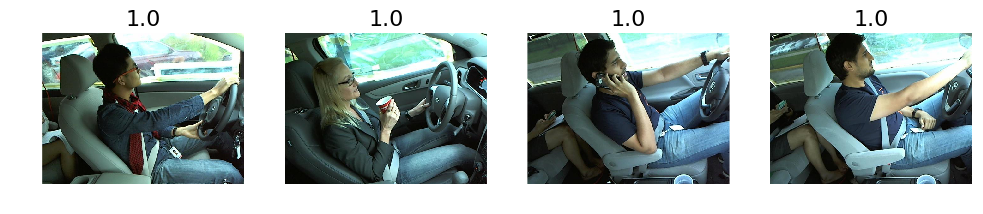

In [51]:
#1. A few correct labels at random
correct = np.where(preds==val_labels[:,1])[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

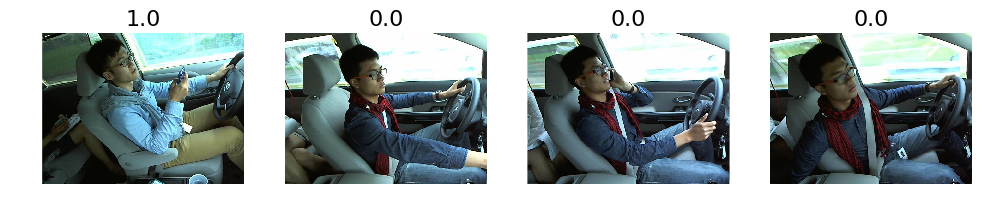

In [52]:
#2. A few incorrect labels at random
incorrect = np.where(preds!=val_labels[:,1])[0]
idx = permutation(incorrect)[:n_view]
plots_idx(idx, probs[idx])

### Submission to Kaggle ([help](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/statefarm.ipynb))

_Note on file structure_: I needed to create a single 'unknown' class for the test set

In [34]:
from IPython.display import FileLink

subm_name = path + 'results/subm.gz'

In [35]:
#Get the classes from the training batch
classes = sorted(trn_batches.class_indices, key=trn_batches.class_indices.get)

AttributeError: 'NumpyArrayIterator' object has no attribute 'class_indices'

In [ ]:
batches, preds = vgg.test(path + 'test', batch_size = batch_size*2)

In [ ]:
#For every image, vgg.test() generates two probabilities 
#based on how we've ordered the directories.
print preds[:5]

filenames = batches.filenames
print filenames[:5]

In [ ]:
submission = pd.DataFrame(preds, columns=classes)
submission.insert(0, 'img', [a[8:] for a in filenames])
submission.head()

In [ ]:
submission.to_csv(subm_name, index=False, compression='gzip')

In [ ]:
FileLink(subm_name)

Then, using the Kaggle CLI:
> `kg submit subm.gz -c state-farm-distracted-driver-detection`

My **multiclass loss** private score on submission is 1.72406. If this competition was still open, it would place me in the top 51.6% (743/1440). According to Jeremy, top 50% is an "ok-ish" model (and top 20% would be "very good"). This score was with nb_epoch = 1. No tweaks from what was taught in class.

My private score with 3 epochs is 1.45654 - an "ok-ish" top 45% (648/1440).